Todo:
    
    1. Review current notebook
    2. Review the anlaysis of Credit card for understanding data and filling missing data
    2. Add Logistic Regression using stats model
    3. Add Feature Selection in Credit card analysis
    4. Review and add methods of reference Feature Selection
    5. Try with other datasets

# 1. Import library

In [193]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import RFE
from sklearn.metrics import roc_auc_score

# 2. Import data

In [194]:
# load dataset
df = pd.read_csv('Credit_Card_Applications.csv')
df.head()

,CustomerID,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,Class
0,15776156,1,22.08,11.46,2,4,4,1.585,0,0,0,1,2,100,1213,0
1,15739548,0,22.67,7.00,2,8,4,0.165,0,0,0,0,2,160,1,0
2,15662854,0,29.58,1.75,1,4,4,1.250,0,0,0,1,2,280,1,0
3,15687688,0,21.67,11.50,1,5,3,0.000,1,1,11,1,2,0,1,1
4,15715750,1,20.17,8.17,2,6,4,1.960,1,1,14,0,2,60,159,1


# 3. Separate train set and test set

In [195]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['CustomerID','Class'], axis=1),
    df['Class'],
    test_size = 0.3,
    random_state = 0)

X_train.shape, X_test.shape

((483, 14), (207, 14))

In [196]:
# I keep a copy of the dataset with all the variables
# to measure the performance of machine learning models
# at the end of the notebook

X_train_original = X_train.copy()
X_test_original = X_test.copy()

original_features = X_train_original.columns
original_features

Index(['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11',
       'A12', 'A13', 'A14'],
      dtype='object')

# 4. Filter method

### 4.1. Remove constant features

In [208]:
# remove constant features
constant_features = [
    feat for feat in X_train.columns if X_train[feat].std() == 0
]
features_to_keep = [var for var in X_train.columns if var not in constant_features]

print(constant_features)
print()
print(features_to_keep)

[]

['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14']


### 4.2. Remove quasi-constant features

In [198]:
# remove quasi-constant features
sel = VarianceThreshold(
    threshold=0.01)  # 0.1 indicates 99% of observations approximately

sel.fit(X_train)  # fit finds the features with low variance

sum(sel.get_support()) # how many not quasi-constant?

14

In [199]:
features_to_keep = X_train.columns[sel.get_support()]
features_to_keep

Index(['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11',
       'A12', 'A13', 'A14'],
      dtype='object')

In [200]:
# sklearn transformations lead to numpy arrays
# here I transform the arrays back to dataframes
# please be mindful of getting the columns assigned
# correctly

X_train= pd.DataFrame(X_train)
X_train.columns = features_to_keep

X_test= pd.DataFrame(X_test)
X_test.columns = features_to_keep

### 4.3. Remove duplicated features

In [201]:
# check for duplicated features in the training set
duplicated_feat = []
for i in range(0, len(X_train.columns)):
    if i % 10 == 0:  # this helps me understand how the loop is going
        print(i)

    col_1 = X_train.columns[i]

    for col_2 in X_train.columns[i + 1:]:
        if X_train[col_1].equals(X_train[col_2]):
            duplicated_feat.append(col_2)
            
len(duplicated_feat)

0
10


0

In [202]:
# remove duplicated features
X_train.drop(labels=duplicated_feat, axis=1, inplace=True)
X_test.drop(labels=duplicated_feat, axis=1, inplace=True)

X_train.shape, X_test.shape

((483, 14), (207, 14))

In [203]:
# I keep a copy of the dataset except constant and duplicated variables
# to measure the performance of machine learning models
# at the end of the notebook

X_train_basic_filter = X_train.copy()
X_test_basic_filter = X_test.copy()

### 4.4. Remove correlated features

In [136]:
# find and remove correlated features
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

corr_features = correlation(X_train, 0.8)
print('correlated features: ', len(set(corr_features)) )

correlated features:  0


In [137]:
# removed correlated  features
X_train.drop(labels=corr_features, axis=1, inplace=True)
X_test.drop(labels=corr_features, axis=1, inplace=True)

X_train.shape, X_test.shape

((483, 14), (207, 14))

In [138]:
# keep a copy of the dataset at  this stage
X_train_corr = X_train.copy()
X_test_corr = X_test.copy()

### 4.5. Remove features using univariate ROC-AUC

In [139]:
# find important features using univariate roc-auc

# loop to build a tree, make predictions and get the roc-auc
# for each feature of the train set

roc_values = []
for feature in X_train.columns:
    clf = DecisionTreeClassifier()
    clf.fit(X_train[feature].fillna(0).to_frame(), y_train)
    y_scored = clf.predict_proba(X_test[feature].fillna(0).to_frame())
    roc_values.append(roc_auc_score(y_test, y_scored[:, 1]))

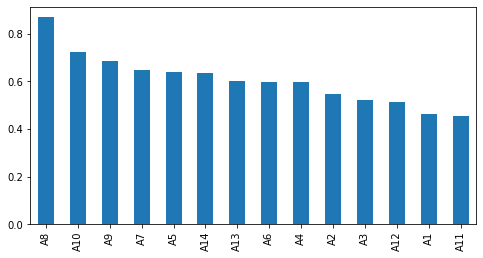

In [141]:
# let's add the variable names and order it for clearer visualisation
roc_values = pd.Series(roc_values)
roc_values.index = X_train.columns
roc_values.sort_values(ascending=False).plot.bar(figsize=(8, 4))

In [142]:
# by removing features with univariate roc_auc == 0.5
# we remove another 30 features

selected_feat = roc_values[roc_values>0.5]
len(selected_feat), X_train.shape[1]

(12, 14)

# 5. Embedded methods

In [144]:
# linear models benefit from feature scaling

scaler = StandardScaler()
scaler.fit(X_train)
scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)

### 5.1. Select features by the regression coefficients

In [145]:
# select features using the coefficient of a non
# regularised logistic regression

sel_ = SelectFromModel(LogisticRegression(C=1000))
sel_.fit(scaled_X_train, y_train)

# remove features with zero coefficient from dataset
# and parse again as dataframe (output of sklearn is
# numpy array)
X_train_coef = pd.DataFrame(sel_.transform(X_train))
X_test_coef = pd.DataFrame(sel_.transform(X_test))

# add the columns name
X_train_coef.columns = X_train.columns[(sel_.get_support())]
X_test_coef.columns = X_train.columns[(sel_.get_support())]

In [146]:
X_train_coef.shape, X_test_coef.shape

((483, 3), (207, 3))

### 5.2. Select features by random forests derived importance 

Random forests are one the most popular machine learning algorithms. They are so successful because they provide in general a good predictive performance, low overfitting and easy interpretability. This interpretability is given by the fact that it is straightforward to derive the importance of each variable on the tree decision. In other words, it is easy to compute how much each variable is contributing to the decision.

Random forests consist of 4-12 hundred decision trees, each of them built over a random extraction of the observations from the dataset and a random extraction of the features. Not every tree sees all the features or all the observations, and this guarantees that the trees are de-correlated and therefore less prone to over-fitting. Each tree is also a sequence of yes-no questions based on a single or combination of features. At each node (this is at each question), the three divides the dataset into 2 buckets, each of them hosting observations that are more similar among themselves and different from the ones in the other bucket. Therefore, the importance of each feature is derived by how "pure" each of the buckets is. 

For classification, the measure of impurity is either the Gini impurity or the information gain/entropy. For regression the  measure of impurity is variance. Therefore, when training a tree, it is possible to compute how much each feature decreases the impurity. The more a feature decreases the impurity, the more important the feature is. In random forests, the impurity decrease from each feature can be averaged across trees to determine the final importance of the variable.

To give you a better intuition, features that are selected at the top of the trees are in general more important than features that are selected at the end nodes of the trees, as generally the top splits lead to bigger information gains.

**Note**
- Random Forests and decision trees in general give preference to features with high cardinality
- Correlated features will be given equal or similar importance, but overall reduced importance compared to the same tree built without correlated counterparts.

http://localhost:8888/notebooks/01-ML/02-General/FeatureSelection/09.2_Random_forest_importance.ipynb

In [148]:
# select features using the impotance derived from
# random forests

sel_ = SelectFromModel(RandomForestClassifier(n_estimators=400))
sel_.fit(scaled_X_train, y_train)

# remove features with zero coefficient from dataset
# and parse again as dataframe (output of sklearn is
# numpy array)
X_train_rf = pd.DataFrame(sel_.transform(X_train))
X_test_rf = pd.DataFrame(sel_.transform(X_test))

# add the columns name
X_train_rf.columns = X_train.columns[(sel_.get_support())]
X_test_rf.columns = X_train.columns[(sel_.get_support())]

In [149]:
X_train_rf.shape, X_test_rf.shape

((483, 7), (207, 7))

In [164]:
# this command let's me visualise those features that were selected.

# sklearn will select those features which importance values
# are greater than the mean of all the coefficients.

sel_.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [165]:
# let's make a list and count the selected features
randomforest_feature = X_train.columns[(sel_.get_support())]
len(randomforest_feature)

14

In [166]:
randomforest_feature

Index(['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11',
       'A12', 'A13', 'A14'],
      dtype='object')

In [167]:
# and now let's plot the distribution of importances

pd.Series(sel_.estimator_.feature_importances_.ravel()).hist()

AttributeError: 'LogisticRegression' object has no attribute 'feature_importances_'

In [168]:
# and now, let's compare the  amount of selected features
# with the amount of features which importance is above the
# mean importance, to make sure we understand the output of
# sklearn

print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients greater than the mean coefficient: {}'.format(
    np.sum(sel_.estimator_.feature_importances_ > sel_.estimator_.feature_importances_.mean())))

total features: 14
selected features: 12


AttributeError: 'LogisticRegression' object has no attribute 'feature_importances_'

Selecting features by using tree derived feature importance is a very srtaightforward, fast and generally accurate way of selecting good features for machine learning. In particular, if you are going to build tree methods.

However, as I said, correlated features will show in a tree similar and lowered importance, compared to what their importance would be if the tree was built without correlated counterparts.

In situations like this, it is better to select features recursively, rather than altogether like I am doing in this lecture.


That is all for this lecture, I hope you enjoyed it and see you in the next one!

### 5.3. Recursive feature selection using random forests importance

Random Forests assign equal or similar importance to features that are highly correlated. In addition, when features are correlated, the importance assigned is lower than the importance attributed to the feature itself, should the tree be built without the correlated counterparts.

Therefore, instead of eliminating features based  on importance by brute force like we did in the previous lecture, we may get a better selection by removing one feature at a time, and recalculating the importance on each round.

This method is an hybrid between embedded and wrapper methods: it is based on computation derived when fitting the model, but it also requires fitting several models.

The cycle is as follows:

- Build random forests using all features
- Remove least important feature
- Build random forests and recalculate importance
- Repeat until a criteria is met

In this situation, when a feature that is highly correlated to another one is removed, then, the importance of the remaining feature increases. This may lead to a better subset feature space selection. On the downside, building several random forests is quite time consuming, in particular if the dataset contains a high number of features.

In [169]:
# first I specify the Random Forest instance, indicating the number of trees

# Then I use the selectFromModel object from sklearn to automatically select the features

# RFE will remove one feature at each iteration, the least  important.
# then it will build another random forest and repeat till a criteria is met.

# in sklearn the criteria to stop is an arbitrary number of features to select, that you need to decide before hand
# not the best solution, but a solution

sel_ = RFE(RandomForestClassifier(n_estimators=100), n_features_to_select=10)
sel_.fit(std_X_train, y_train)

RFE(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                     class_weight=None, criterion='gini',
                                     max_depth=None, max_features='auto',
                                     max_leaf_nodes=None, max_samples=None,
                                     min_impurity_decrease=0.0,
                                     min_impurity_split=None,
                                     min_samples_leaf=1, min_samples_split=2,
                                     min_weight_fraction_leaf=0.0,
                                     n_estimators=100, n_jobs=None,
                                     oob_score=False, random_state=None,
                                     verbose=0, warm_start=False),
    n_features_to_select=10, step=1, verbose=0)

In [170]:
# this command let's me visualise those features that were selected.
sel_.get_support()

array([False,  True,  True, False,  True,  True,  True,  True,  True,
        True, False, False,  True,  True])

In [171]:
# let's add the variable names and order it for clearer visualisation
selected_feat = X_train.columns[(sel_.get_support())]
len(selected_feat)

10

In [172]:
# let's display the list of features
selected_feat

Index(['A2', 'A3', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A13', 'A14'], dtype='object')

### 5.4. Gradient Boosted trees importance

Similarly to selecting features using Random Forests derived feature importance, you can select features based on the importance derived by gradient boosted trees. And you can do that in one go, or in a recursive manner, depending on how much time you have, how many features are in the dataset, and whether they are correlated or not.

I will demonstrate how to select features using Gradient boosted trees derived importance using sklearn on a classification problem, using the Paribas claims dataset from Kaggle.

In [173]:
# first I will select features all together in one go
# by contemplating their importance after fitting only
# 1 gradient boosted tree

sel_ = SelectFromModel(GradientBoostingClassifier())
sel_.fit(std_X_train, y_train)

SelectFromModel(estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                     criterion='friedman_mse',
                                                     init=None,
                                                     learning_rate=0.1,
                                                     loss='deviance',
                                                     max_depth=3,
                                                     max_features=None,
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                               

In [174]:
# let's add the variable names and order it for clearer visualisation
selected_feat = X_train.columns[(sel_.get_support())]
len(selected_feat)

1

In [175]:
selected_feat

Index(['A8'], dtype='object')

In [176]:
# next I will select features recursively for comparison

sel_ = RFE(GradientBoostingClassifier(), n_features_to_select=len(selected_feat))
sel_.fit(std_X_train, y_train)

RFE(estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                         criterion='friedman_mse', init=None,
                                         learning_rate=0.1, loss='deviance',
                                         max_depth=3, max_features=None,
                                         max_leaf_nodes=None,
                                         min_impurity_decrease=0.0,
                                         min_impurity_split=None,
                                         min_samples_leaf=1,
                                         min_samples_split=2,
                                         min_weight_fraction_leaf=0.0,
                                         n_estimators=100,
                                         n_iter_no_change=None,
                                         presort='deprecated',
                                         random_state=None, subsample=1.0,
                                         tol=0.0001, validation_f

In [177]:
# let's add the variable names and order it for clearer visualisation
selected_feat_rfe = X_train.columns[(sel_.get_support())]
len(selected_feat_rfe)

1

In [178]:
selected_feat_rfe

Index(['A8'], dtype='object')

### 5.3. Lasso Regularization

Regularization consists in adding a penalty to the different parameters of the machine learning model to reduce the freedom of the model and in other words to avoid overfitting. In linear model regularization, the penalty is applied over the coefficients that multiply each of the predictors. From the different types of regularization, Lasso or L1 has the property that is able to shrink some of the coefficients to zero. Therefore, that feature can be removed from the model

In [150]:
# First, specify the Logistic Regression model and selection the Lasso (L1) penalty
sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l1',solver='liblinear'))

# Second, use the selectFromModel object from sklearn, which will select
# in theory the features which coefficients are non-zero
sel_.fit(std_X_train, y_train)

SelectFromModel(estimator=LogisticRegression(C=1, class_weight=None, dual=False,
                                             fit_intercept=True,
                                             intercept_scaling=1, l1_ratio=None,
                                             max_iter=100, multi_class='auto',
                                             n_jobs=None, penalty='l1',
                                             random_state=None,
                                             solver='liblinear', tol=0.0001,
                                             verbose=0, warm_start=False),
                max_features=None, norm_order=1, prefit=False, threshold=None)

In [151]:
# visualize those features that were kept
sel_.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [152]:
# Make a list with the selected features

lasso_features = X_train.columns[(sel_.get_support())]

print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(lasso_features)))
print('features with coefficients shrank to zero: {}'.format(
    np.sum(sel_.estimator_.coef_ == 0)))

total features: 14
selected features: 14
features with coefficients shrank to zero: 0


In [153]:
# we can identify the removed features like this:
removed_feats = X_train.columns[(sel_.estimator_.coef_ == 0).ravel().tolist()]
removed_feats

Index([], dtype='object')

In [154]:
lasso_features

Index(['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11',
       'A12', 'A13', 'A14'],
      dtype='object')

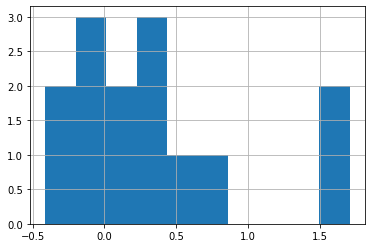

In [155]:
# plot the distribution of coefficients
pd.Series(sel_.estimator_.coef_.ravel()).hist()

As expected, some coefficients are positive and some are negative, suggesting that some features are negatively associated with the outcome (the more of the feature the less of the outcome) and viceversa.

However, the absolute value of the coefficients inform about the importance of the feature on the outcome, and not the sign. Therefore, the feature selection is done filtering on absolute values of coefficients. See below.

In [156]:
# the feature importance is informed by the absolute value of
# the coefficient, and not the sign.
# therefore, let's recalculate the mean using the absolute values instead

np.abs(sel_.estimator_.coef_).mean()

0.47701051608056694

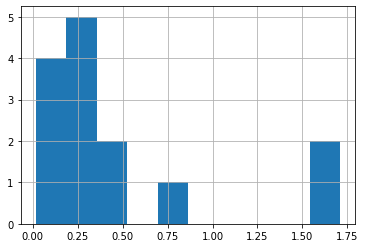

In [157]:
# and now let's plot the histogram of absolute coefficients

pd.Series(np.abs(sel_.estimator_.coef_).ravel()).hist()

In [158]:
# and now, let's compare the  amount of selected features
# with the amount of features which coefficient is above the
# mean coefficient, to make sure we understand the output of
# sklearn

print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(lasso_features)))
print('features with coefficients greater than the mean coefficient: {}'.format(
    np.sum(np.abs(sel_.estimator_.coef_) > np.abs(sel_.estimator_.coef_).mean())))

total features: 14
selected features: 14
features with coefficients greater than the mean coefficient: 4


### 5.4. Regression coefficients are affected by regularisation

As I mentioned previously, regularisation applies a penalty on the coefficients, in order to reduce their influence and create models that generalise better. This is very good to improve  model performance. However, it masks the true relationship between the predictor X and the outcome Y. Let's explore why.

http://localhost:8888/notebooks/01-ML/02-General/FeatureSelection/08.3_Regression_coefficients_and_regularisation.ipynb

In [159]:
# I build 4 different models, from a highly regularised one
# to a non regularised one (C=1000)
coefs_df = []
for c in [1, 10, 100, 1000]:
    logit = LogisticRegression(C=c, penalty='l2')
    logit.fit(scaler.transform(X_train.fillna(0)), y_train)
    
    # store the coefficients of the variables in a list
    coefs_df.append(pd.Series(logit.coef_.ravel()))

In [160]:
# now I create a dataframe with the coefficients for all
# the variables for the 4 different logistic regression models

coefs = pd.concat(coefs_df, axis=1)
coefs.columns = [1, 10, 100, 1000]
coefs.index = X_train.columns
coefs.head()

,1,10,100,1000
A1,-0.033460,-0.044539,-0.047205,-0.047514
A2,-0.267938,-0.314190,-0.322951,-0.323939
A3,-0.156090,-0.190003,-0.196532,-0.197273
A4,0.300837,0.312363,0.313613,0.313741
A5,0.826030,0.864826,0.871259,0.872000


In [161]:
coefs.columns = np.log([1, 10, 100, 1000])
coefs.head()

,0.000000,2.302585,4.605170,6.907755
A1,-0.033460,-0.044539,-0.047205,-0.047514
A2,-0.267938,-0.314190,-0.322951,-0.323939
A3,-0.156090,-0.190003,-0.196532,-0.197273
A4,0.300837,0.312363,0.313613,0.313741
A5,0.826030,0.864826,0.871259,0.872000


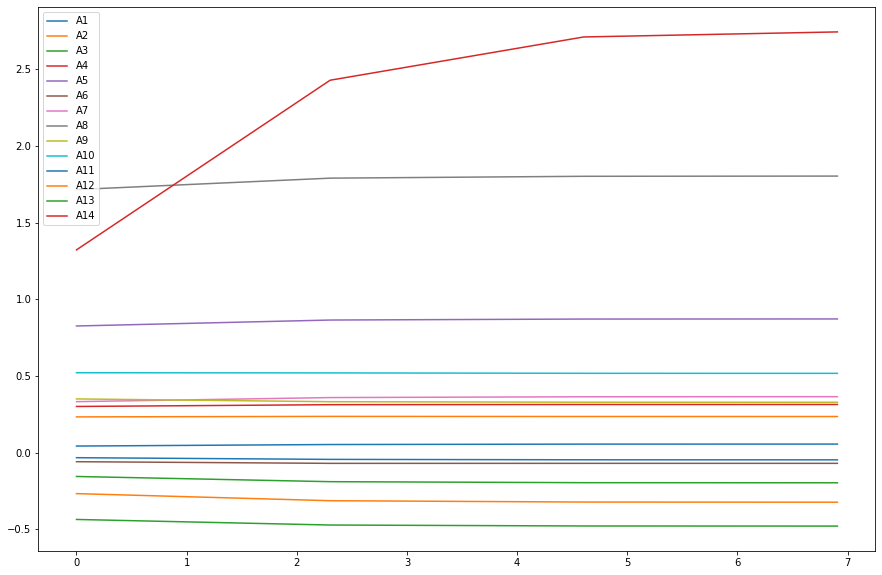

In [162]:
# plot the change in coefficients with the penalty
coefs.T.plot(figsize=(15,10))

### 5.5 L2 Regularization

In [163]:
l1_logit = LogisticRegression(C=1, penalty='l2')
l1_logit.fit(scaler.transform(X_train.fillna(0)), y_train)

# I count the number of coefficients with zero values
# and it is zero, as expected
np.sum(l1_logit.coef_ == 0)

0

### Hybrid Recursive Feature Elimination

http://localhost:8888/notebooks/01-ML/02-General/FeatureSelection/11.02_Hybrid_Recursive_feature_elimination.ipynb

This method consists of the following steps:

1) Rank the features according to their importance derived from a machine learning algorithm: it can be tree importance, or LASSO / Ridge, or the linear / logistic regression coefficients.

2) Remove one feature -the least important- and build a machine learning algorithm utilising the remaining features.

3) Calculate a performance metric of your choice: roc-auc, mse, rmse, accuracy.

4) If the metric decreases by more of an arbitrarily set threshold, then that feature is important and should be kept. Otherwise, we can remove that feature.

5) Repeat steps 2-4 until all features have been removed (and therefore evaluated) and the drop in performance assessed.


I call this a hybrid method because:

- it combines the importance derived from the machine learning algorithm like embedded methods,
- and it removes as well one feature at a time, and calculates a new metric based on the new subset of features and the machine learning algorithm of choice, like wrapper methods.

The difference between this method and the step backwards feature selection we learned in previous lectures lies in that it does not remove all features first in order to determine which one to remove. It removes the least important one, based on the machine learning model derived important. And then, it makes an assessment as to whether that feature should be removed or not. So it removes each feature only once during selection, whereas step backward feature selection removes all the features at each step of selection.

This method is therefore faster than wrapper methods and generally better than embedded methods. In practice it works extremely well. It does also account for correlations (depending on how stringent you set the arbitrary performance drop threshold). On the downside, the drop in performance assessed to decide whether the feature should be kept or removed, is set arbitrarily. The smaller the drop the more features will be selected, and vice versa.

I will demonstrate how to select features using this method on a regression and classification problem. For classification I will use the Paribas claims dataset from Kaggle. For regression, the House Price dataset from Kaggle.

**Note** For the demonstration, I will use XGBoost, but this method is useful for any machine learning algorithm. In fact, the importance of the features are determined specifically for the algorithm used. Therefore, different algorithms may return different subsets of important features

In [182]:
# the first step of this procedure  consists in building
# a machine learning algorithm using all the available features
# and then determine the importance of the features according
# to the algorithm

# set the seed for reproducibility
seed_val = 1000000000
np.random.seed(seed_val)

# build initial model using all the features
model_all_features = xgb.XGBClassifier(
    nthread=10, max_depth=4, n_estimators=500, learning_rate=0.05)

model_all_features.fit(X_train, y_train)

# calculate the roc-auc in the test set
y_pred_test = model_all_features.predict_proba(X_test)[:, 1]
auc_score_all = roc_auc_score(y_test, y_pred_test)
print('Test all features xgb ROC AUC=%f' % (auc_score_all))

Test all features xgb ROC AUC=0.925824


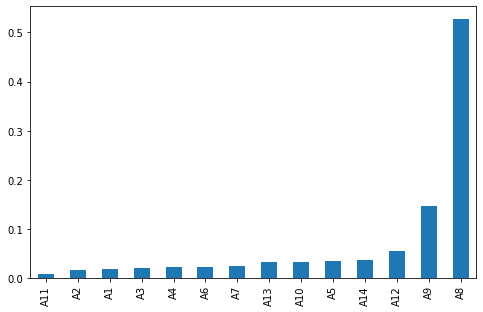

In [183]:
# the second step consist of deriving the importance of 
# each feature and ranking them from the least to the most
# important

# get feature name and importance
features = pd.Series(model_all_features.feature_importances_)
features.index = X_train.columns

# sort the features by importance
features.sort_values(ascending=True, inplace=True)

# plot
features.plot.bar(figsize=(8,5))

In [184]:
# view the list of ordered features
features = list(features.index)
print(features)

['A11', 'A2', 'A1', 'A3', 'A4', 'A6', 'A7', 'A13', 'A10', 'A5', 'A14', 'A12', 'A9', 'A8']


In [185]:
# the final step consists in removing one at a time
# all the features, from the least to the most
# important, and build an xgboost at each round.

# once we build the model, we calculate the new roc-auc
# if the new roc-auc is smaller than the original one
# (with all the features), then that feature that was removed
# was important, and we should keep it.
# otherwise, we should remove the feature

# recursive feature elimination:

# first we arbitrarily set the drop in roc-auc
# if the drop is below this threshold,
# the feature will be removed
tol = 0.0005

print('doing recursive feature elimination')

# we initialise a list where we will collect the
# features we should remove
features_to_remove = []

# set a counter to know how far ahead the loop is going
count = 1

# now we loop over all the features, in order of importance:
# remember that features is the list of ordered features
# by importance
for feature in features:
    print()
    print('testing feature: ', feature, ' which is feature ', count,
          ' out of ', len(features))
    count = count + 1

    # initialise model
    model_int = xgb.XGBClassifier(
        nthread=10, max_depth=4, n_estimators=500, learning_rate=0.05)

    # fit model with all variables minus the removed features
    # and the feature to be evaluated
    model_int.fit(
        X_train.drop(features_to_remove + [feature], axis=1), y_train)

    # make a prediction over the test set
    y_pred_test = model_int.predict_proba(
        X_test.drop(features_to_remove + [feature], axis=1))[:, 1]

    # calculate the new roc-auc
    auc_score_int = roc_auc_score(y_test, y_pred_test)
    print('New Test ROC AUC={}'.format((auc_score_int)))

    # print the original roc-auc with all the features
    print('All features Test ROC AUC={}'.format((auc_score_all)))

    # determine the drop in the roc-auc
    diff_auc = auc_score_all - auc_score_int

    # compare the drop in roc-auc with the tolerance
    # we set previously
    if diff_auc >= tol:
        print('Drop in ROC AUC={}'.format(diff_auc))
        print('keep: ', feature)
        print
    else:
        print('Drop in ROC AUC={}'.format(diff_auc))
        print('remove: ', feature)
        print
        # if the drop in the roc is small and we remove the
        # feature, we need to set the new roc to the one based on
        # the remaining features
        auc_score_all = auc_score_int
        
        # and append the feature to remove to the collecting
        # list
        features_to_remove.append(feature)

# now the loop is finished, we evaluated all the features
print('DONE!!')
print('total features to remove: ', len(features_to_remove))

# determine the features to keep (those we won't remove)
features_to_keep = [x for x in features if x not in features_to_remove]
print('total features to keep: ', len(features_to_keep))

doing recursive feature elimination

testing feature:  A11  which is feature  1  out of  14
New Test ROC AUC=0.9279184917158636
All features Test ROC AUC=0.9258236526375928
Drop in ROC AUC=-0.0020948390782707937
remove:  A11

testing feature:  A2  which is feature  2  out of  14
New Test ROC AUC=0.930917920396115
All features Test ROC AUC=0.9279184917158636
Drop in ROC AUC=-0.0029994286802513814
remove:  A2

testing feature:  A1  which is feature  3  out of  14
New Test ROC AUC=0.9314416301656827
All features Test ROC AUC=0.930917920396115
Drop in ROC AUC=-0.0005237097695677262
remove:  A1

testing feature:  A3  which is feature  4  out of  14
New Test ROC AUC=0.9220148543134641
All features Test ROC AUC=0.9314416301656827
Drop in ROC AUC=0.009426775852218627
keep:  A3

testing feature:  A4  which is feature  5  out of  14
New Test ROC AUC=0.9247762330984575
All features Test ROC AUC=0.9314416301656827
Drop in ROC AUC=0.006665397067225243
keep:  A4

testing feature:  A6  which is featu

In [186]:
# capture the 56 selected features
seed_val = 1000000000
np.random.seed(seed_val)

# build initial model
final_xgb = xgb.XGBClassifier(
    nthread=10, max_depth=4, n_estimators=500, learning_rate=0.05)

# fit the model with the selected features
final_xgb.fit(X_train[features_to_keep], y_train)

# make predictions
y_pred_test = final_xgb.predict_proba(X_test[features_to_keep])[:, 1]

# calculate roc-auc
auc_score_final = roc_auc_score(y_test, y_pred_test)
print('Test selected features ROC AUC=%f' % (auc_score_final))
print('Test all features ROC AUC=%f' % (auc_score_all))

Test selected features ROC AUC=0.933156
Test all features ROC AUC=0.933156


As you can see, the xgb model built with 56 features shows a similar performance than the one built with the total features (0.715 vs 0.713).

We may not be able to get this right from the beginning though, as we did here. This method of feature selection does require that you try a few different tolerances / thresholds until you find the right number of features.

Why don't you go ahead and try different values? Try with lower and bigger thresholds and get a feeling of how much this affects the number of selected features.

### Hybrid Recursive Feature Addition

http://localhost:8888/notebooks/01-ML/02-General/FeatureSelection/11.03_Hybrid_Recursive_feature_addition.ipynb

This method consists of the following steps:

1) Rank the features according to their importance derived from a machine learning algorithm: it can be tree importance, or LASSO / Ridge, or the linear / logistic regression coefficients.

2) Build a machine learning model with only 1 feature, the most important one, and calculate the model metric for performance.

3) Add one feature -the most important- and build a machine learning algorithm utilising the added and any feature from previous rounds.

4) Calculate a performance metric of your choice: roc-auc, mse, rmse, accuracy.

5) If the metric increases by more than an arbitrarily set threshold, then that feature is important and should be kept. Otherwise, we can remove that feature.

6) Repeat steps 2-5 until all features have been removed (and therefore evaluated) and the drop in performance assessed.


I call this a hybrid method because:

- it combines the importance derived from the machine learning algorithm like embedded methods,
- and it adds as well one feature at a time, and calculates a new metric based on the new subset of features and the machine learning algorithm of choice, like wrapper methods.

The difference between this method and the step forward feature selection we learned in previous lectures lies in that it does not add all possible features first, in order to determine which one to keep. It adds the most important one, based on the machine learning model derived important. And then, it makes an assessment as to whether that feature should be kept or not. And then it moves to the next feature.

This method is therefore faster than wrapper methods and generally better than embedded methods. In practice it works extremely well. It does also account for correlations (depending on how stringent you set the arbitrary performance drop threshold). On the downside, the increase in performance assessed to decide whether the feature should be kept or removed, is set arbitrarily. The smaller the increase the more features will be selected, and vice versa.

I will demonstrate how to select features using this method on a regression and classification problem. For classification I will use the Paribas claims dataset from Kaggle. For regression, the House Price dataset from Kaggle.

**Note** For the demonstration, I will use XGBoost, but this method is useful for any machine learning algorithm. In fact, the importance of the features are determined specifically for the algorithm used. Therefore, different algorithms may return different subsets of important features.

In [187]:
# the first step of this procedure  consists in building
# a machine learning algorithm using all the available features
# and then determine the importance of the features according
# to the algorithm

# set the seed for reproducibility
seed_val = 1000000000
np.random.seed(seed_val)

# build initial model using all the features
model_all_features = xgb.XGBClassifier(
    nthread=10, max_depth=4, n_estimators=500, learning_rate=0.05)

model_all_features.fit(X_train, y_train)

# calculate the roc-auc in the test set
y_pred_test = model_all_features.predict_proba(X_test)[:, 1]
auc_score_all = roc_auc_score(y_test, y_pred_test)
print('Test all features xgb ROC AUC=%f' % (auc_score_all))

Test all features xgb ROC AUC=0.925824


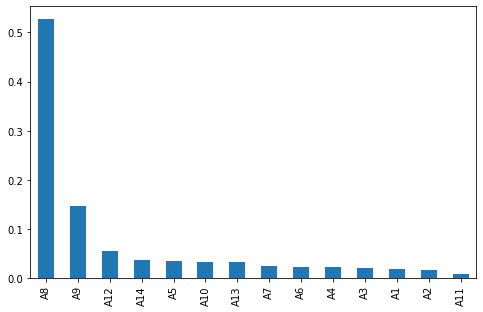

In [188]:
# the second step consist of deriving the importance of 
# each feature and ranking them from the most to the least
# important

# get feature name and importance
features = pd.Series(model_all_features.feature_importances_)
features.index = X_train.columns

# sort the features by importance
features.sort_values(ascending=False, inplace=True)

# plot
features.plot.bar(figsize=(8,5))

In [189]:
# view the list of ordered features
features = list(features.index)
print(features)

['A8', 'A9', 'A12', 'A14', 'A5', 'A10', 'A13', 'A7', 'A6', 'A4', 'A3', 'A1', 'A2', 'A11']


In [190]:
# next, we need to build a machine learning
# algorithm using only the most important feature

# set the seed for reproducibility
seed_val = 1000000000
np.random.seed(seed_val)

# build initial model using all the features
model_one_feature = xgb.XGBClassifier(
    nthread=10, max_depth=4, n_estimators=500, learning_rate=0.05)

# train using only the most important feature
model_one_feature.fit(X_train[features[0]].to_frame(), y_train)

# calculate the roc-auc in the test set
y_pred_test = model_one_feature.predict_proba(X_test[features[0]].to_frame())[:, 1]
auc_score_first = roc_auc_score(y_test, y_pred_test)
print('Test one feature xgb ROC AUC=%f' % (auc_score_first))

Test one feature xgb ROC AUC=0.870310


In [191]:
# the final step consists in adding one at a time
# all the features, from the most to the least
# important, and build an xgboost at each round.

# once we build the model, we calculate the new roc-auc
# if the new roc-auc is bigger than the original one
# (with one feature), then that feature that was added
# was important, and we should keep it.
# otherwise, we should remove the feature

# recursive feature addition:

# first we arbitrarily set the increase in roc-auc
# if the increase is above this threshold,
# the feature will be kept
tol = 0.001

print('doing recursive feature addition')

# we initialise a list where we will collect the
# features we should keep
features_to_keep = [features[0]]

# set a counter to know how far ahead the loop is going
count = 1

# now we loop over all the features, in order of importance:
# remember that features is the list of ordered features
# by importance
for feature in features[1:]:
    print()
    print('testing feature: ', feature, ' which is feature ', count,
          ' out of ', len(features))
    count = count + 1

    # initialise model
    model_int = xgb.XGBClassifier(
        nthread=10, max_depth=4, n_estimators=500, learning_rate=0.05)

    # fit model with the selected features
    # and the feature to be evaluated
    model_int.fit(
        X_train[features_to_keep + [feature] ], y_train)

    # make a prediction over the test set
    y_pred_test = model_int.predict_proba(
        X_test[features_to_keep + [feature] ])[:, 1]

    # calculate the new roc-auc
    auc_score_int = roc_auc_score(y_test, y_pred_test)
    print('New Test ROC AUC={}'.format((auc_score_int)))

    # print the original roc-auc with one feature
    print('All features Test ROC AUC={}'.format((auc_score_first)))

    # determine the increase in the roc-auc
    diff_auc = auc_score_int - auc_score_first

    # compare the increase in roc-auc with the tolerance
    # we set previously
    if diff_auc >= tol:
        print('Increase in ROC AUC={}'.format(diff_auc))
        print('keep: ', feature)
        print
        # if the increase in the roc is bigger than the threshold
        # we keep the feature and re-adjust the roc-auc to the new value
        # considering the added feature
        auc_score_first = auc_score_int
        
        # and we append the feature to keep to the list
        features_to_keep.append(feature)
    else:
        # we ignore the feature
        print('Increase in ROC AUC={}'.format(diff_auc))
        print('remove: ', feature)
        print


# now the loop is finished, we evaluated all the features
print('DONE!!')
print('total features to keep: ', len(features_to_keep))

doing recursive feature addition

testing feature:  A9  which is feature  1  out of  14
New Test ROC AUC=0.8955437059607694
All features Test ROC AUC=0.8703104170634165
Increase in ROC AUC=0.02523328889735288
keep:  A9

testing feature:  A12  which is feature  2  out of  14
New Test ROC AUC=0.9086840601790135
All features Test ROC AUC=0.8955437059607694
Increase in ROC AUC=0.01314035421824411
keep:  A12

testing feature:  A14  which is feature  3  out of  14
New Test ROC AUC=0.9077794705770329
All features Test ROC AUC=0.9086840601790135
Increase in ROC AUC=-0.0009045896019805877
remove:  A14

testing feature:  A5  which is feature  4  out of  14
New Test ROC AUC=0.9078270805560845
All features Test ROC AUC=0.9086840601790135
Increase in ROC AUC=-0.0008569796229289661
remove:  A5

testing feature:  A10  which is feature  5  out of  14
New Test ROC AUC=0.9146829175395164
All features Test ROC AUC=0.9086840601790135
Increase in ROC AUC=0.005998857360502874
keep:  A10

testing feature:  A

In [192]:
# capture the 8 selected features
seed_val = 1000000000
np.random.seed(seed_val)

# build initial model
final_xgb = xgb.XGBClassifier(
    nthread=10, max_depth=4, n_estimators=500, learning_rate=0.05)

# fit the model with the selected features
final_xgb.fit(X_train[features_to_keep], y_train)

# make predictions
y_pred_test = final_xgb.predict_proba(X_test[features_to_keep])[:, 1]

# calculate roc-auc
auc_score_final = roc_auc_score(y_test, y_pred_test)
print('Test selected features ROC AUC=%f' % (auc_score_final))

Test selected features ROC AUC=0.922348


# Compare the performance in Random Forest

In [105]:
# create a function to build random forests and compare performance in train and test set

def run_randomForests(X_train, X_test, y_train, y_test):
    rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=4)
    rf.fit(X_train, y_train)
    print('Train set')
    pred = rf.predict_proba(X_train)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    print('Test set')
    pred = rf.predict_proba(X_test)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

In [106]:
# original
run_randomForests(X_train_original,X_test_original,y_train, y_test)

Train set
Random Forests roc-auc: 0.9677687380993596
Test set
Random Forests roc-auc: 0.9318225099980956


In [108]:
# filter methods - basic
run_randomForests(X_train_basic_filter,X_test_basic_filter,y_train, y_test)

Train set
Random Forests roc-auc: 0.9677687380993596
Test set
Random Forests roc-auc: 0.9318225099980956


In [109]:
# filter methods - correlation
run_randomForests(X_train_corr,X_test_corr,y_train, y_test)

Train set
Random Forests roc-auc: 0.9677687380993596
Test set
Random Forests roc-auc: 0.9318225099980956


In [110]:
# filter methods - univariate roc-auc
run_randomForests(X_train[selected_feat.index],X_test_corr[selected_feat.index],y_train, y_test)

Train set
Random Forests roc-auc: 0.9678899082568807
Test set
Random Forests roc-auc: 0.9292991811083603


In [111]:
# embedded methods - Logistic regression coefficients
run_randomForests(X_train_coef,
                  X_test_coef,
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.9487450233685303
Test set
Random Forests roc-auc: 0.9175395162826128


Selecting features using the logistic regression coefficients gives a slightly worse performance than the univariate roc-auc (0.798 vs 0.795). However, keep in mind that the univariate model is using 90 features vs the only 28 used by the coefficients selection method. This means that many of those 90 features are still redundant, and we could potentially reduce the feature space further without loosing performance significantly.

In [121]:
# embedded methods - Random forests
run_randomForests(X_train_rf,
                  X_test_rf,
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.966920546996711
Test set
Random Forests roc-auc: 0.9351552085317082


Well this was a big jump!! We can see how by selecting features using random forest importance, we reduce the feature space up to only 16 features, and yet the algorithm shows a greater predictive performance compared to the one using more features (0.813 vs 0.798)!!!

We can see the power of feature selection now!

# Logistic Regression

In [112]:
# create a function to build logistic regression and compare performance in train and test set

def run_logistic(X_train, X_test, y_train, y_test):
    # function to train and test the performance of logistic regression
    logit = LogisticRegression(random_state=44)
    logit.fit(X_train, y_train)
    print('Train set')
    pred = logit.predict_proba(X_train)
    print('Logistic Regression roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    print('Test set')
    pred = logit.predict_proba(X_test)
    print('Logistic Regression roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

In [114]:
# original
scaler = StandardScaler().fit(X_train_original)

run_logistic(scaler.transform(X_train_original),scaler.transform(X_test_original),y_train, y_test)

Train set
Logistic Regression roc-auc: 0.9466678206681669
Test set
Logistic Regression roc-auc: 0.910207579508665


In [115]:
# filter methods - basic
scaler = StandardScaler().fit(X_train_basic_filter)

run_logistic(scaler.transform(X_train_basic_filter),scaler.transform(X_test_basic_filter),y_train, y_test)

Train set
Logistic Regression roc-auc: 0.9466678206681669
Test set
Logistic Regression roc-auc: 0.910207579508665


In [116]:
# filter methods - correlation
scaler = StandardScaler().fit(X_train_corr)

run_logistic(scaler.transform(X_train_corr),scaler.transform(X_test_corr),y_train, y_test)

Train set
Logistic Regression roc-auc: 0.9466678206681669
Test set
Logistic Regression roc-auc: 0.910207579508665


In [117]:
# filter methods - univariate roc-auc
scaler = StandardScaler().fit(X_train[selected_feat.index])

run_logistic(scaler.transform(X_train[selected_feat.index]),
             scaler.transform(X_test_corr[selected_feat.index]),
                  y_train, y_test)

Train set
Logistic Regression roc-auc: 0.9466851306906698
Test set
Logistic Regression roc-auc: 0.9122071986288326


In [118]:
# embedded methods - Logistic regression coefficients
run_randomForests(X_train_coef,
                  X_test_coef,
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.9487450233685303
Test set
Random Forests roc-auc: 0.9175395162826128


In this case, we can see that the selection of features using the feature coefficient led to a better performing logistic regression model (0.795 vs 0.794) compared to univariate feature selection. In addition, the new model has 28 vs 90 features, so it is a win-win :)

That is all for this lecture. I hope you enjoyed it!

In [122]:
# embedded methods - Random Forests importance

scaler = StandardScaler().fit(X_train_rf)

run_logistic(
    scaler.transform(X_train_rf), scaler.transform(X_test_rf), y_train, y_test)

Train set
Logistic Regression roc-auc: 0.938999480699325
Test set
Logistic Regression roc-auc: 0.9197295753189868


With Logistic regression we were not so lucky. This makes sense on the other hand, because selection of features by random forest importance, optimises feature selection for tree based methods, as it is able to capture non-linearities that linear regression can not.

Therefore, if we are selecting features for a linear model, it is better to use selection procedures targeted to those models, like importance by regression coefficient or Lasso. And if we are selecting features for trees, it is better to use tree derived importance.

That is all for this lecture. I hope you enjoyed it!

# Compare performance using Gradient Boosting Tree

In [179]:
# create a function to build gradient boosted trees
# and compare performance in train and test set


def run_gradientboosting(X_train, X_test, y_train, y_test):
    rf = GradientBoostingClassifier(
        n_estimators=200, random_state=39, max_depth=4)
    rf.fit(X_train, y_train)
    print('Train set')
    pred = rf.predict_proba(X_train)
    print('Random Forests roc-auc: {}'.format(
        roc_auc_score(y_train, pred[:, 1])))
    print('Test set')
    pred = rf.predict_proba(X_test)
    print('Random Forests roc-auc: {}'.format(
        roc_auc_score(y_test, pred[:, 1])))

In [180]:
# features selected recursively
run_gradientboosting(X_train[selected_feat_rfe].fillna(0),
                  X_test[selected_feat_rfe].fillna(0),
                  y_train, y_test)# features selected altogether

Train set
Random Forests roc-auc: 0.8580491604639086
Test set
Random Forests roc-auc: 0.8703104170634165


In [181]:
# features selected altogether
run_gradientboosting(X_train[selected_feat].fillna(0),
                  X_test[selected_feat].fillna(0),
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.8580491604639086
Test set
Random Forests roc-auc: 0.8703104170634165
